In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from itertools import groupby
from string import ascii_lowercase
from nltk import pos_tag, word_tokenize
from nltk.stem import PorterStemmer
from nltk import RegexpParser
import nltk

## Loading Dataset

In [2]:
df = pd.read_csv('./Data/job_descriptions-jobstreet-new.csv', dtype='str')
rows, cols = df.shape

print("The shape of the dataframe is:", df.shape)

The shape of the dataframe is: (163964, 10)


## Exploratory Data Analysis - Before

### Null Values

In [3]:
df.describe()

,JOB_URL,JOB_TITLE,COMPANY,LOCATION,SALARY,JOB_KEYWORDS,POST_DATE,JOB_DESCRIPTION,JOB_SPECIALIZATION,JOB_CLASS
count,163964,163964,163964,130371,77349,29762,130395,163964,130387,163964
unique,163964,58994,18560,400,5673,5679,113,71369,1061,428
top,https://www.jobstreet.com.sg/en/job/group-acco...,Accountant,PERSOLKELLY Singapore Pte Ltd (Formerly Kelly ...,Singapore,Full-time,Shuttle Service Provided Meals Provided Bi...,1d ago,Responsibilities:Contract administration--- in...,Computer/Information Technology--- IT-Software,Actuarial
freq,1,696,5370,46396,7455,118,14694,71,6549,792


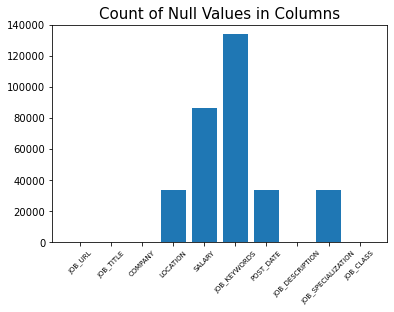

In [4]:
plt.rc('xtick', labelsize= 7)
plt.rc('ytick', labelsize= 10)
plt.rc('axes', titlesize = 15)
plt.bar(df.columns, rows - df.describe().loc['count', :])
plt.xticks(rotation = 45)
plt.ylim([0, 140000])
plt.title("Count of Null Values in Columns")
plt.show()

### Class Imbalance

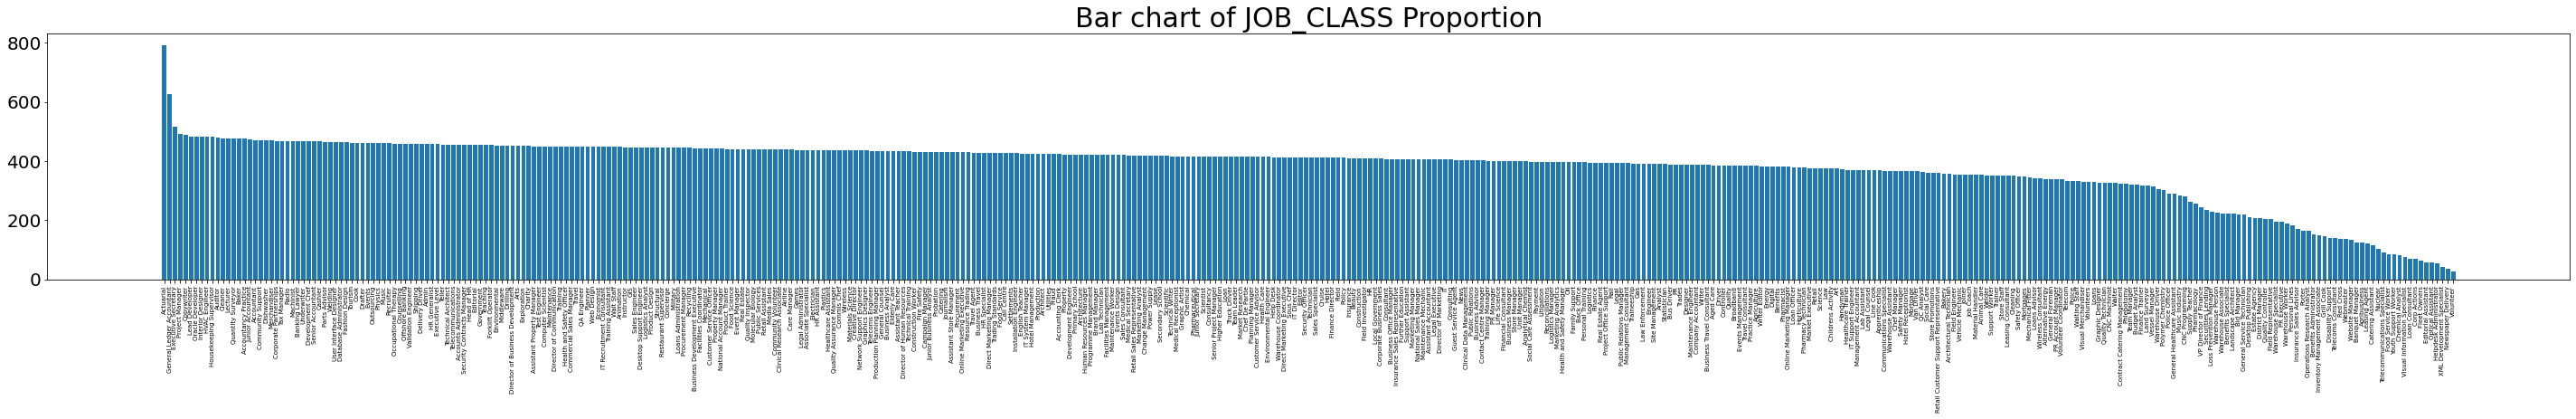

In [5]:
class_count = df['JOB_CLASS'].value_counts()

# Data visualisation - bar chart
plt.figure(figsize = (50, 5))
plt.rc('xtick', labelsize= 7)
plt.rc('ytick', labelsize= 20)
plt.rc('axes', titlesize = 30)
plt.bar(class_count.index, class_count)
plt.title("Bar chart of JOB_CLASS Proportion")
plt.xticks(rotation = 90)
plt.show()

There are too much disparity in count of JOB_CLASS and proportion. Therefore, it is recommended to select only few JOB_CLASS for modelling. 

### Job Description

In [6]:
words = df['JOB_DESCRIPTION'].str.lower()
text = " ".join(detail for detail in words)
print("There are {} words in the combination of all descriptions.".format(len(text)))

There are 350699547 words in the combination of all descriptions.


Word Cloud takes a while to generate (~5 min each)

In [7]:
# wordcloud = WordCloud().generate(text)

# wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation = "bilinear")
# plt.axis("off")
# plt.show()

In [8]:
# Setting stopwords for a more valid exploration using WordCloud

stopwords = set(STOPWORDS)
additional_stop_words = ["required", "support", "ability", "will", "well", "able", "responsible", "ensure", 
                  "candidates", "shortlisted", "experience", "least", "year", "years", "personal", 
                  "manage", "knowledge", "work", "looking", "develop", "protected", "pte", "ltd",
                  "part", "assigned", "assist", "maintain", "regret", "lead", "accordance", "full", "time", 
                  "relevant", "description", "e","g", "resume", "liase", "company", "role", "team", 
                  "working", "privacy", "policy", "email", "closely", "compliance", "one", "need",
                  "report", "meet", "build", "coordinate", "follow", "implementation", "make", "position", 
                  "apply", "now", "full", "ensuring", "liase", "managing", "procedure", "understand", 
                  "help", "provide"]
stopwords.update(additional_stop_words)

# wordcloud = WordCloud(stopwords = stopwords, background_color = "white").generate(text)
# plt.imshow(wordcloud, interpolation = 'bilinear')
# plt.axis("off")
# plt.show()

## Data Preprocessing

In [9]:
df.dropna(subset=['JOB_DESCRIPTION'], inplace=True)
df.drop_duplicates(inplace=True)
df['JOB_DESCRIPTION'] = df['JOB_DESCRIPTION'].str.lower()

### Cleaning Job Description Column

In [10]:
df["JOB_DESCRIPTION"] = df["JOB_DESCRIPTION"].str.replace("\W+",' ',regex=True)
# Save a copy of df for later
df_salary = df.copy()

### Class Rebalancing

In [11]:
class_count = df['JOB_CLASS'].value_counts()
ub, lb = np.quantile(class_count, [0.75, 0.25])

df['COUNT'] = df['JOB_CLASS'].apply(lambda x: class_count[x])
df = df.loc[(df['COUNT'] >= lb) & (df['COUNT'] <= ub), :]
df.reset_index(drop=True, inplace=True)

print("There are now {} unique job classes in the dataset.".format(df.JOB_CLASS.nunique()))
print("The shape of the dataset is {}.".format(df.shape))

There are now 216 unique job classes in the dataset.
The shape of the dataset is (88526, 11).


## Exploratory Data Analysis - After

### Class Balance

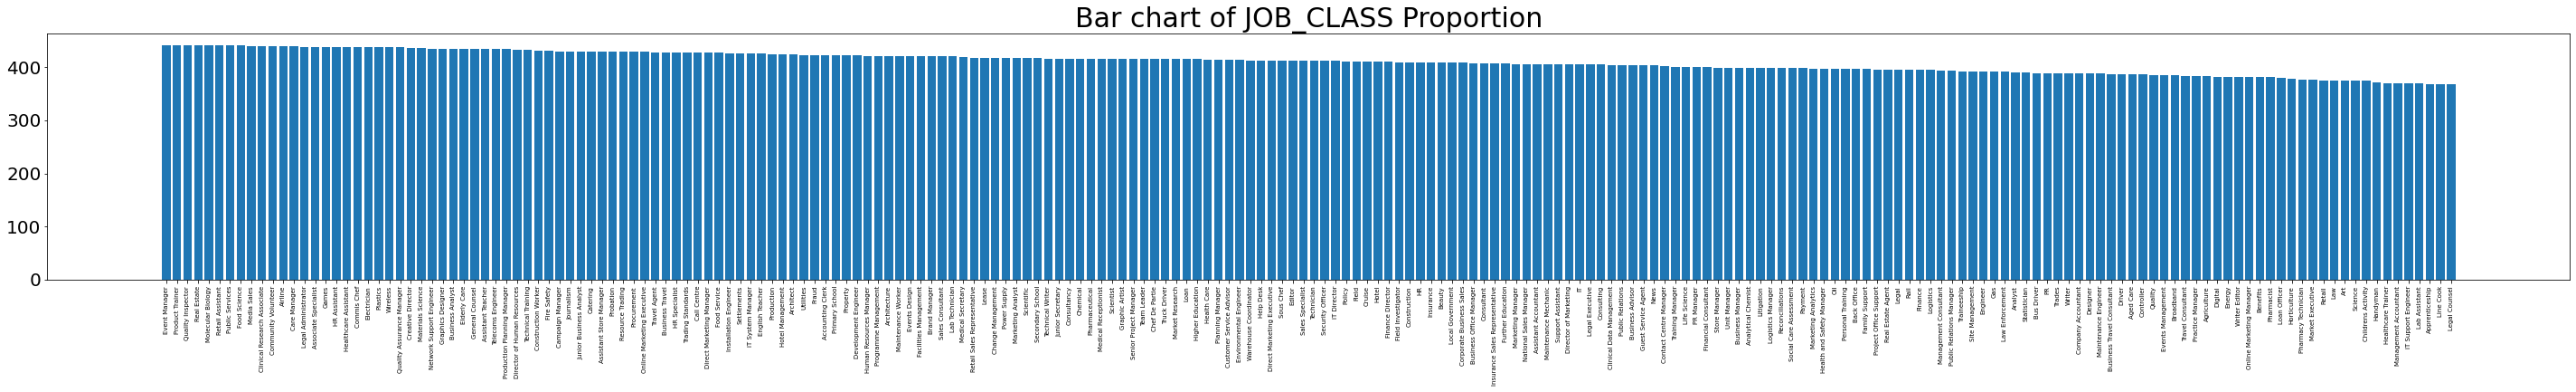

In [12]:
class_count = df['JOB_CLASS'].value_counts()

# Data visualisation - bar chart
plt.figure(figsize = (50, 5))
plt.rc('xtick', labelsize= 7)
plt.rc('ytick', labelsize= 20)
plt.rc('axes', titlesize = 30)
plt.bar(class_count.index, class_count)
plt.title("Bar chart of JOB_CLASS Proportion")
plt.xticks(rotation = 90)
plt.show()

## Machine Learning Models

### Heuristic Rule-Based Approach

In [13]:
# sample of 10 job descriptions
df_sample = df.sample(n=10, replace=True, random_state=2022)
df_sample.head()

,JOB_URL,JOB_TITLE,COMPANY,LOCATION,SALARY,JOB_KEYWORDS,POST_DATE,JOB_DESCRIPTION,JOB_SPECIALIZATION,JOB_CLASS,COUNT
86909,https://sg.indeed.com/m/basecamp/viewjob?viewt...,Associate-APAC Asset & Liability Management - ...,Natixis - Singapore - DBUSingapore,NaN,$30 an hour,NaN,NaN,description de l entreprise natixis corporate ...,NaN,Change Management,417
1244,https://www.jobstreet.com.sg/en/job/airport-sc...,Airport Screening Officer | Gross $2;300 + Joi...,Certis Group,East,SGD 1.9K - 2.3K monthly,NaN,1d ago,the 4 roles of an aviation screening officer a...,Services--- Armed Forces--- Customer Service,Airline,439
16557,https://www.jobstreet.com.sg/en/job/customer-s...,Customer Service Officer (Front Desk),JH KIM TAEKWONDO SINGAPORE,Singapore,SGD 1.8K - 2.5K monthly,Premier Taekwondo school with a strong presenc...,3d ago,being one of the premier taekwondo schools in ...,Admin/Human Resources--- Clerical/Administrati...,Customer Service Advisor,414
46769,https://www.jobstreet.com.sg/en/job/patient-se...,Patient Service Associate (Clinics) (1-Year/ 2...,Ng Teng Fong General Hospital,Singapore,NaN,NaN,1d ago,the challengesthe incumbent shall be responsib...,Healthcare--- Practitioner/Medical Asst--- Ser...,Medical Receptionist,416
71920,https://www.jobstreet.com.sg/en/job/senior-gra...,Senior Graphic Designer cum Videographer/Editor,Shopping Bag (S) Pte Ltd,Central,NaN,NaN,3d ago,we are seeking for a passionate and creative m...,Arts/Media/Communications--- Arts/Creative Design,Writer Editor,382


In [14]:
regex_phrases = pd.read_csv("regex_phrases.csv")
regex_phrases_list = regex_phrases['Words'].to_list()
regex_phrases_list[:5]

['ability to', 'able to', 'advanced', 'demonstrated', 'develop']

In [15]:
job_descriptions = df_sample['JOB_DESCRIPTION']
for jd in job_descriptions:
    jd = re.sub(r"[,.;@#?!&$-//\\_]+", ' ', str(jd))
    jd = jd.lower()

In [16]:
job_descriptions = df_sample['JOB_DESCRIPTION'].str.lower()
job_descriptions = job_descriptions.str.replace(r"[,.;@#?!&$-/\_]+", ' ', regex=True).astype('str')

In [17]:
df_eval = pd.DataFrame({'Job_ID': df_sample.index})
df_eval['Predicted'] = ""

In [18]:
def flatten(x):
    result = []
    for el in x:
        if hasattr(el, "__iter__") and not isinstance(el, str):
            result.extend(flatten(el))
        else:
            result.append(el)
    return result

In [19]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
n = 0

for jds in job_descriptions: 
    job_keywords = []

    for phrase in regex_phrases_list:
        before_keyword, keyword, after_keyword = str(jds).partition(str(phrase))
        split = after_keyword.split()
        three_words_after = split[0:3]
        if  three_words_after != []:

            # remove stop words and keep only nouns and adjectives
            three_words_after = [word for word in three_words_after if (word not in stop_words) and (pos_tag(word_tokenize(word))[0][1][1] is not 'N' or 'J')]
            job_keywords.append(three_words_after) 
    job_keywords = flatten(job_keywords)
    # df_eval.loc[n].predicted = job_keywords
    df_eval.at[n, 'Predicted'] = job_keywords
    n += 1

df_eval

<>:16: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:16: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\JunHo\AppData\Local\Temp/ipykernel_11776/3567504515.py:16: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  three_words_after = [word for word in three_words_after if (word not in stop_words) and (pos_tag(word_tokenize(word))[0][1][1] is not 'N' or 'J')]


,Job_ID,Predicted
0,86909,"[work, part, ment, japan, required, analytical..."
1,1244,"[perform, shift, work, similar, security, perf..."
2,16557,"[multi, task, conduct, represent, terested, ca..."
3,46769,"[work, customer, related, front, interpersonal..."
4,71920,"[capture, snippets, edit, broad, post, product..."
5,57176,"[ing, marketing, strategy, corporate, communic..."
6,2066,"[ly, singaporean]"
7,81944,"[work, well, communication, negotiation, procu..."
8,61584,"[commit, weekends, call, center, virtual, inte..."
9,56629,"[work, deal, service, customersan, rapport, cl..."


In [20]:
# load in test set of manually selected keywords within the same 10 job descriptions as above
df_test = pd.read_csv("job_test.csv")
df_test

,Job_ID,Test
0,86909,"liquidity, regulatory, risk, governance, stand..."
1,1244,"observant, responsible, screening, security, s..."
2,16557,"customer, bookings, payments, administrative, ..."
3,46769,"schedule, payment, billing, counselling, telec..."
4,71920,"social, media, marketing, campaigns, illustrat..."
5,57176,"communications, media, crisis, branding, press..."
6,2066,"repair, servicing, maintenance, equipment, tro..."
7,81944,"procurement, proactive, purchasing, sourcing, ..."
8,61584,"training, relationships, sales, customers, call,"
9,56629,"service, customers, communicator, analytical, ..."


In [21]:
import ast
i = 0
total_accuracy = []

for predict in df_eval['Predicted']:
    num_correct_predict = len(set(predict) & set(list(df_test['Test'][i].split(", "))))
    accuracy = round(len(set(predict) & set(list(df_test['Test'][i].split(", ")))) / len(list(df_test['Test'][i].split(", "))), 2)

    print(num_correct_predict, "correct predictions, accuracy:" , accuracy)
    total_accuracy.append(accuracy)
    i += 1 

4 correct predictions, accuracy: 0.27
1 correct predictions, accuracy: 0.2
2 correct predictions, accuracy: 0.2
5 correct predictions, accuracy: 0.45
1 correct predictions, accuracy: 0.04
5 correct predictions, accuracy: 0.28
0 correct predictions, accuracy: 0.0
3 correct predictions, accuracy: 0.18
0 correct predictions, accuracy: 0.0
5 correct predictions, accuracy: 0.36


In [22]:
results = df_test.merge(df_eval, on='Job_ID', how='left')
results

,Job_ID,Test,Predicted
0,86909,"liquidity, regulatory, risk, governance, stand...","[work, part, ment, japan, required, analytical..."
1,1244,"observant, responsible, screening, security, s...","[perform, shift, work, similar, security, perf..."
2,16557,"customer, bookings, payments, administrative, ...","[multi, task, conduct, represent, terested, ca..."
3,46769,"schedule, payment, billing, counselling, telec...","[work, customer, related, front, interpersonal..."
4,71920,"social, media, marketing, campaigns, illustrat...","[capture, snippets, edit, broad, post, product..."
5,57176,"communications, media, crisis, branding, press...","[ing, marketing, strategy, corporate, communic..."
6,2066,"repair, servicing, maintenance, equipment, tro...","[ly, singaporean]"
7,81944,"procurement, proactive, purchasing, sourcing, ...","[work, well, communication, negotiation, procu..."
8,61584,"training, relationships, sales, customers, call,","[commit, weekends, call, center, virtual, inte..."
9,56629,"service, customers, communicator, analytical, ...","[work, deal, service, customersan, rapport, cl..."


In [23]:
results['match_results'] = total_accuracy
results

,Job_ID,Test,Predicted,match_results
0,86909,"liquidity, regulatory, risk, governance, stand...","[work, part, ment, japan, required, analytical...",0.27
1,1244,"observant, responsible, screening, security, s...","[perform, shift, work, similar, security, perf...",0.20
2,16557,"customer, bookings, payments, administrative, ...","[multi, task, conduct, represent, terested, ca...",0.20
3,46769,"schedule, payment, billing, counselling, telec...","[work, customer, related, front, interpersonal...",0.45
4,71920,"social, media, marketing, campaigns, illustrat...","[capture, snippets, edit, broad, post, product...",0.04
5,57176,"communications, media, crisis, branding, press...","[ing, marketing, strategy, corporate, communic...",0.28
6,2066,"repair, servicing, maintenance, equipment, tro...","[ly, singaporean]",0.00
7,81944,"procurement, proactive, purchasing, sourcing, ...","[work, well, communication, negotiation, procu...",0.18
8,61584,"training, relationships, sales, customers, call,","[commit, weekends, call, center, virtual, inte...",0.00
9,56629,"service, customers, communicator, analytical, ...","[work, deal, service, customersan, rapport, cl...",0.36


In [24]:
import statistics
print("Total prediction accuracy for sample :" ,statistics.mean(total_accuracy))

Total prediction accuracy for sample : 0.198


### Naive Bayes Classifier

In [25]:
X = df['JOB_DESCRIPTION']
y = df['JOB_CLASS']

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [27]:
# Add custom stop words from EDA
from sklearn.feature_extraction import text

new_stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=2022)

vect = TfidfVectorizer(stop_words=new_stop_words, max_features=100000, ngram_range=(1,2))
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

clf = MultinomialNB()
clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)

In [29]:
acc = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {acc:.5f}')

Model Accuracy: 0.38962


In [30]:
model_comparison = pd.DataFrame(columns=['Num Classes', 'Num Test', 'Precision', 'Recall', 'F1-Score'])

clf_report = classification_report(y_test, y_pred, output_dict=True)['weighted avg']
model_comparison.loc[0, :] = [len(y.value_counts()), clf_report['support'], clf_report['precision'], clf_report['recall'], clf_report['f1-score']]

In [31]:
feature_array = vect.get_feature_names_out()
features_numbers = len(feature_array)
n_max = 20

output = pd.DataFrame(columns=['JOB_CLASS', 'SKILLS'])

for i in range(0,len(clf.classes_)):
    class_prob_indices_sorted = clf.feature_log_prob_[i, :].argsort()[::-1]
    raw_skills = np.take(feature_array, class_prob_indices_sorted[:n_max])
    output.loc[i, :] = np.array([clf.classes_[i], raw_skills], dtype=object)

In [32]:
output.head()

,JOB_CLASS,SKILLS
0,Accounting Clerk,"[accounting, accounts, invoices, ar, payment, ..."
1,Aged Care,"[care, nursing, patients, residents, patient, ..."
2,Agriculture,"[wildlife, trading, agriculture, research, man..."
3,Airline,"[customer, aircraft, airlines, cargo, service,..."
4,Analyst,"[business, data, analysis, analyst, financial,..."


In [33]:
output.loc[output['JOB_CLASS'] == "Property", 'SKILLS'].values

array([array(['estate', 'property', 'management', 'real estate', 'building',
              'leasing', 'facilities', 'maintenance', 'real', 'tenants', 'works',
              'tenancy', 'facilities management', 'contractors', 'lease', 'good',
              'properties', 'diploma', 'marketing', 'day'], dtype=object)        ],
      dtype=object)

### Reducing number of classes

In [34]:
class_list = df['JOB_CLASS'].unique()
class_sample_size = [100, 50]
np.random.seed(2022)
i = 1


for s in class_sample_size:
    keep_list = np.random.choice(class_list, s)
    df_new = df.loc[df["JOB_CLASS"].isin(keep_list),:]

    X = df_new['JOB_DESCRIPTION']
    y = df_new['JOB_CLASS']

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=2022)

    vect = TfidfVectorizer(stop_words=new_stop_words, max_features=100000, ngram_range=(1,2))
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)

    clf = MultinomialNB()
    clf.fit(X_train_dtm, y_train)
    y_pred = clf.predict(X_test_dtm)

    clf_report = classification_report(y_test, y_pred, output_dict=True)['weighted avg']
    model_comparison.loc[i, :] = [len(y.value_counts()), clf_report['support'], clf_report['precision'], clf_report['recall'], clf_report['f1-score']]
    i += 1

model_comparison

,Num Classes,Num Test,Precision,Recall,F1-Score
0,216,22132,0.417079,0.389617,0.371991
1,81,8290,0.609759,0.569361,0.563834
2,48,4902,0.649666,0.625459,0.618858


## Insights

### Exploring skills of similar job titles

In [35]:
accounting_classes = ["Accountancy Practice","Accountant","Accounting Clerk","Accounts Administrator","Assistant Accountant","Company Accountant","General Ledger Accountant","Junior Accountant","National Account Manager","Senior Accountant"]
output.loc[output['JOB_CLASS'].isin(accounting_classes), :]

,JOB_CLASS,SKILLS
0,Accounting Clerk,"[accounting, accounts, invoices, ar, payment, ..."
10,Assistant Accountant,"[accounting, accounts, monthly, tax, finance, ..."
38,Company Accountant,"[accounting, financial, tax, finance, monthly,..."


### Exploring effect of skills on salary

In [36]:
df_salary = df.copy()
website_regex = re.compile('(?:\.)(.+?)(?:\.com)')
df_salary['WEBSITE'] = df_salary['JOB_URL'].apply(lambda x: website_regex.findall(x)[0])
df_salary = df_salary.loc[df_salary['WEBSITE'] == 'jobstreet', :]

df_salary.dropna(subset=['JOB_DESCRIPTION', 'SALARY'], inplace=True)
df_salary.drop_duplicates(inplace=True)
df_salary.reset_index(drop=True, inplace=True)

print("The shape of the dataset is {}.".format(df_salary.shape))

The shape of the dataset is (28757, 12).


In [37]:
df_salary["SALARY"] = df_salary["SALARY"].str.replace("\xa0"," ")
clean_salary=[]

for i in range(df_salary.shape[0]):
    salary=df_salary["SALARY"][i]
    if re.match("SGD.*K.*K.*monthly",salary):
        clean_salary.append(int((float(salary.split(" ")[1][:-1])+float(salary.split(" ")[3][:-1]))*500))
    else:
        df_salary.drop([i],inplace=True)
df_salary.reset_index(drop=True,inplace=True)
df_salary["SALARY_CLEANED"]=clean_salary
df_salary.head()

,JOB_URL,JOB_TITLE,COMPANY,LOCATION,SALARY,JOB_KEYWORDS,POST_DATE,JOB_DESCRIPTION,JOB_SPECIALIZATION,JOB_CLASS,COUNT,WEBSITE,SALARY_CLEANED
0,https://www.jobstreet.com.sg/en/job/accounts-a...,Accounts Assistant,HS Xpress Pte Ltd,Pioneer,SGD 1.8K - 2.2K monthly,Lunch will be provided (Monday to Friday) Fr...,1d ago,report to accounts managermainly focus on acco...,Accounting/Finance--- General/Cost Accounting,Accounting Clerk,423,jobstreet,2000
1,https://www.jobstreet.com.sg/en/job/accounts-a...,Accounts Assistant - 6 months Contract,Singapore Aero Support Services Pte Ltd,Changi,SGD 1.7K - 2.5K monthly,NaN,1d ago,roles responsibilitieshandle accounts payablem...,Accounting/Finance--- General/Cost Accounting,Accounting Clerk,423,jobstreet,2100
2,https://www.jobstreet.com.sg/en/job/account-as...,Account Assistant,BORDEN EAGLE GROUP,Bukit Merah,SGD 1.6K - 2.5K monthly,NaN,1d ago,responsible for daily transactions and data en...,Accounting/Finance--- General/Cost Accounting,Accounting Clerk,423,jobstreet,2050
3,https://www.jobstreet.com.sg/en/job/accounts-a...,Accounts Assistant,Goodwood Ship Management Pte Ltd,West - Others,SGD 1.8K - 2.2K monthly,NaN,3d ago,responsibilities part of accounts payable team...,Accounting/Finance--- General/Cost Accounting,Accounting Clerk,423,jobstreet,2000
4,https://www.jobstreet.com.sg/en/job/temp-accou...,Temp Accounts Assistant *Immediate*,WOK HEY PTE. LTD.,Ang Mo Kio,SGD 1.7K - 2.1K monthly,Outstanding development opportunities Attrac...,16h ago,key responsibilitiescheck and document invoice...,Accounting/Finance--- General/Cost Accounting,Accounting Clerk,423,jobstreet,1900


In [38]:
class_count = df_salary['SALARY_CLEANED'].value_counts()
ub, lb = np.quantile(class_count, [1, 0.5])

df_salary['COUNT'] = df_salary['SALARY_CLEANED'].apply(lambda x: class_count[x])
df_salary = df_salary.loc[(df_salary['COUNT'] >= lb) & (df_salary['COUNT'] <= ub), :]
df_salary.reset_index(drop=True, inplace=True)

print("The shape of the dataset is {}.".format(df_salary.shape))

The shape of the dataset is (27760, 13).


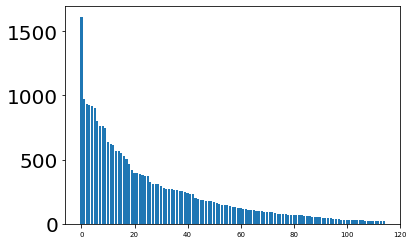

In [39]:
plt.bar(np.arange(len(df_salary['SALARY_CLEANED'].value_counts())), df_salary['SALARY_CLEANED'].value_counts())
plt.show()

In [40]:
df_salary.describe()

,COUNT,SALARY_CLEANED
count,27760.000000,27760.000000
mean,546.899280,3835.549784
std,390.681342,1814.669592
min,21.000000,1400.000000
25%,250.000000,2600.000000
50%,506.000000,3300.000000
75%,800.000000,4500.000000
max,1614.000000,13500.000000


In [41]:
X = df_salary['JOB_DESCRIPTION']
y = df_salary['SALARY_CLEANED']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=2022)

vect = TfidfVectorizer(stop_words=new_stop_words, max_features=500, ngram_range=(1,1))
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm = np.hstack( (X_train_dtm.toarray(), np.ones((X_train_dtm.shape[0],1))) )
X_test_dtm = vect.transform(X_test)
X_test_dtm = np.hstack( (X_test_dtm.toarray(), np.ones((X_test_dtm.shape[0],1))) )

In [42]:
print(X_test_dtm.shape)

(6940, 501)


In [43]:
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error

reg = OLS(y_train, X_train_dtm).fit_regularized(alpha=0.1, L1_wt=1)
y_pred = reg.predict(X_test_dtm)

mse_training = mean_squared_error(reg.predict(X_train_dtm), y_train)
mse_testing = mean_squared_error(reg.predict(X_test_dtm), y_test)

print("training mse: {}, testing mse: {}".format(mse_training, mse_testing))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(mse_training), np.sqrt(mse_testing)))

training mse: 1701318.915338571, testing mse: 1739377.0805225244
training rmse: 1304.3461639222048, testing rmse: 1318.854457672462


In [44]:
index_names = {k: v for k, v in sorted(vect.vocabulary_.items(), key=lambda item: item[1])}.keys()
index_names = list(index_names)
index_names.extend(['const'])

In [45]:
result = pd.DataFrame({'coeff': reg.params})
result.index = index_names
result.sort_values('coeff',ascending=False).head(20)

,coeff
leadership,4799.328715
global,4710.621018
10,4699.207556
strategy,4366.781468
proven,3971.576954
sg,3843.087249
degree,3787.886792
leading,3207.775707
www,3116.561058
consultant,2890.475309


In [46]:
result.sort_values('coeff',ascending=False).tail(20)

,coeff
meticulous,-1049.067335
line,-1096.198978
administrative,-1234.196363
days,-1299.667673
applicants,-1351.113455
objectives,-1368.429571
potential,-1401.323413
attention,-1437.510093
collection,-1443.443212
access,-1471.751268


### Exploring the most common skills

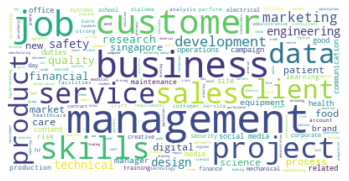

In [47]:
all_skills = output['SKILLS'].explode()
skills = ' '.join(all_skills)

skill_wordcloud = WordCloud().generate(skills)

skill_wordcloud = WordCloud(max_font_size = 50, background_color = "white").generate(skills)
plt.figure()
plt.imshow(skill_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()